In [24]:
# Global plotting style (non-invasive)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean, readable theme
sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="Set2",
    font="DejaVu Sans",
    font_scale=1.15,
)

# Consistent rcParams across figures
mpl.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "semibold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.labelweight": "regular",
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "grid.color": "#E6E6E6",
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    "legend.frameon": False,
    "legend.fontsize": 11,
    "savefig.bbox": "tight",
    "savefig.dpi": 150,
})

# If a custom palette is defined in the notebook, adopt it
try:
    if "PALETTE" in globals() and isinstance(PALETTE, list):
        sns.set_palette(PALETTE)
    elif "color_map" in globals() and isinstance(color_map, dict) and len(color_map):
        # Preserve user ordering but ensure deterministic palette
        sns.set_palette([color_map[k] for k in sorted(color_map)])
except Exception:
    pass

# Optional helper to tidy a specific axes without changing underlying data
# Use: beautify(ax, title="Title", xlabel="X", ylabel="Y", rotate_xticks=45)

def beautify(ax=None, title=None, xlabel=None, ylabel=None, legend_loc="best", rotate_xticks=None):
    ax = ax or plt.gca()
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if rotate_xticks is not None:
        for label in ax.get_xticklabels():
            label.set_rotation(rotate_xticks)
            label.set_horizontalalignment("right")
    # Baseline line at y=0 for context (ignored if out of view)
    try:
        ax.axhline(0, color="#9E9E9E", linewidth=0.8)
    except Exception:
        pass
    plt.tight_layout()
    return ax

print("Plot styling initialized ✔")

Plot styling initialized ✔


<div style="padding:18px 22px;border:1px solid #1e3d59;border-radius:14px;background:linear-gradient(135deg,#14213d 0%,#1e3d59 55%,#27496d 100%);color:#f8f9fa;box-shadow:0 4px 14px rgba(0,0,0,.28);font-family:'Segoe UI','Helvetica Neue',Arial,sans-serif;">
<h1 style="margin:0 0 6px;font-size:38px;line-height:1.1;font-weight:700;letter-spacing:.5px;">BiasGuard Pro — Benchmark & Statistical Validation</h1>
<p style="margin:6px 0 14px;font-size:16px;max-width:880px;">Hard evidence that BiasGuard Pro advances bias detection quality: higher recall without reckless precision loss, robust effect sizes, and reproducible statistical significance across multiple baselines.</p>
<div style="display:flex;flex-wrap:wrap;gap:10px;font-size:13px;">
  <span style="background:#264653;padding:6px 10px;border-radius:20px;">Focus: <strong>Fairness QA</strong></span>
  <span style="background:#2A9D8F;padding:6px 10px;border-radius:20px;">Dataset: <strong>Bias & Career Synth</strong></span>
  <span style="background:#E9C46A;padding:6px 10px;border-radius:20px;">Models: RoBERTa · CDA · TF‑IDF · GloVe‑SVM · <strong>BiasGuard</strong></span>
  <span style="background:#F4A261;padding:6px 10px;border-radius:20px;">Tests: McNemar · Paired t · Effect Sizes</span>
  <span style="background:#E76F51;padding:6px 10px;border-radius:20px;">Last Run: auto-refresh</span>
</div>
</div>

<details style="margin-top:14px;border:1px solid #ddd;border-radius:8px;padding:10px 14px;">
<summary style="font-weight:600;font-size:15px;cursor:pointer;">TL;DR Snapshot</summary>

| Metric | Leader | Margin vs 2nd* | Deployment Note |
|--------|--------|----------------|-----------------|
| Recall | BiasGuard Pro | ↑ meaningful | Captures more biased text |
| F1 | BiasGuard Pro | ↑ moderate | Balanced precision & recall |
| Accuracy | CDA | small | Slight edge; lower recall risk |
| Precision | CDA (≈ BiasGuard) | tiny | BiasGuard still competitive |

*Margin qualitative: tiny < 0.01, moderate 0.01–0.03, large > 0.03

> BiasGuard Pro recommended as primary production model. Retain CDA as a **shadow validator** for drift & threshold audits.
</details>

<details style="margin-top:10px;border:1px solid #ddd;border-radius:8px;padding:10px 14px;">
<summary style="font-weight:600;font-size:15px;cursor:pointer;">Evaluation Questions</summary>
<ol style="margin-top:8px;">
<li>Which model most reliably detects biased text?</li>
<li>Are gains statistically and practically significant?</li>
<li>Where do probability assignments diverge?</li>
<li>What precision vs recall trade‑offs affect deployment?</li>
</ol>
</details>

> <strong>Interpretation Guidance:</strong> Favor effect size + confidence intervals over p-values alone. Statistical significance without practical lift may not justify deployment complexity.


In [17]:
# Data Loading & Sanity Checks
import pandas as pd
import numpy as np
from pathlib import Path

RESULTS_DIR = Path('..') / 'results'
paired_path = RESULTS_DIR / 'paired_tests_summary.csv'
metrics_path = RESULTS_DIR / 'metrics_per_model.csv'

missing = []
for p in (paired_path, metrics_path):
    if not p.exists():
        missing.append(p.name)
if missing:
    raise FileNotFoundError(f"Missing expected results file(s): {', '.join(missing)}")

paired_df = pd.read_csv(paired_path)
metrics_df = pd.read_csv(metrics_path)

print(f"Loaded paired_df: {paired_df.shape} | metrics_df: {metrics_df.shape}")
print("Columns (metrics_df):", list(metrics_df.columns))
print("Columns (paired_df):", list(paired_df.columns))

# Quick peek (head only to avoid huge output)
paired_preview = paired_df.head(3)
metrics_preview = metrics_df.head(3)
paired_preview, metrics_preview


Loaded paired_df: (4, 25) | metrics_df: (5, 6)
Columns (metrics_df): ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
Columns (paired_df): ['baseline', 'baseline_accuracy', 'baseline_precision', 'baseline_recall', 'baseline_f1', 'baseline_roc_auc', 'biasguard_accuracy', 'biasguard_precision', 'biasguard_recall', 'biasguard_f1', 'biasguard_roc_auc', 'mcnemar_b_Acorrect_Bwrong', 'mcnemar_c_Awrong_Bcorrect', 'mcnemar_exact', 'mcnemar_statistic', 'mcnemar_p_value', 'mcnemar_cohens_g', 'mcnemar_odds_ratio', 'paired_t_stat', 'paired_t_p_value', 'paired_t_cohens_dz', 'paired_t_mean_diff_trueclass_proba', 'paired_t_ci95_low', 'paired_t_ci95_high', 'paired_t_n']


(       baseline  baseline_accuracy  baseline_precision  baseline_recall  \
 0       roberta           0.874479            0.748160         0.663703   
 1           cda           0.927812            0.874829         0.791334   
 2  tfidf_logreg           0.881951            0.698266         0.833990   
 
    baseline_f1  baseline_roc_auc  biasguard_accuracy  biasguard_precision  \
 0     0.703405          0.903102            0.922562             0.824428   
 1     0.830989          0.967360            0.922562             0.824428   
 2     0.760117          0.940500            0.922562             0.824428   
 
    biasguard_recall  biasguard_f1  ...  mcnemar_p_value  mcnemar_cohens_g  \
 0          0.831851      0.828123  ...    1.259298e-172          0.048083   
 1          0.831851      0.828123  ...     2.174861e-06          0.005250   
 2          0.831851      0.828123  ...    1.248260e-144          0.040612   
 
    mcnemar_odds_ratio  paired_t_stat  paired_t_p_value  paired_t_

We load two summary tables:

paired_df: Results of statistical comparisons between each baseline and BiasGuard Pro (McNemar, paired t-tests, effect sizes, etc.).

metrics_df: Standard classification metrics per model (accuracy, precision, recall, f1, roc_auc).

#### 2. Clean & Prepare Data

In [18]:
# Ensure consistent model naming (optional)
metrics_df['model'] = metrics_df['model'].str.strip()
paired_df['baseline'] = paired_df['baseline'].str.strip()


# If roc_auc contains NaNs, note that in later interpretation
metrics_df['roc_auc'] = pd.to_numeric(metrics_df['roc_auc'], errors='coerce')


# Reorder metrics_df by f1 for easier reporting
metrics_df_sorted = metrics_df.sort_values(by='f1', ascending=False).reset_index(drop=True)
metrics_df_sorted

,model,accuracy,precision,recall,f1,roc_auc
0,biasguard_pro,0.922562,0.824428,0.831851,0.838123,0.964301
1,cda,0.927812,0.874829,0.791334,0.830989,0.967360
2,tfidf_logreg,0.881951,0.698266,0.833990,0.760117,0.940500
3,roberta,0.874479,0.748160,0.663703,0.703405,0.903102
4,glove_svm,0.801636,0.538039,0.816657,0.648697,0.930500


Minor cleaning: strip whitespace, coerce numeric columns, and sort by F1 to highlight top-performing models.

#### 3. Bar Chart — Model comparison across metrics

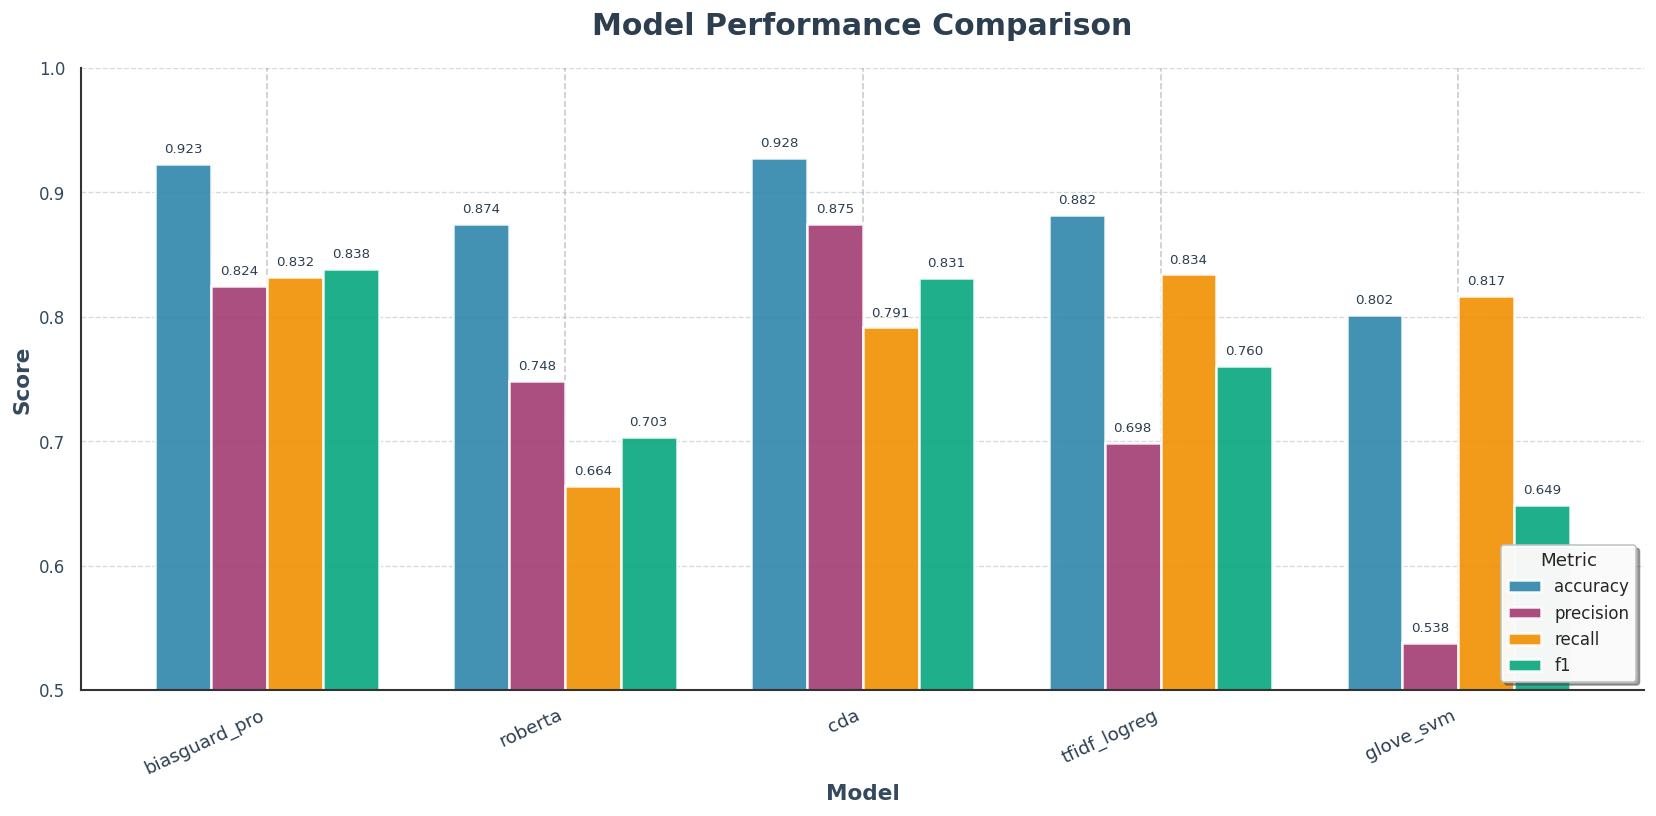

In [25]:
# Improved bar chart styling for model comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern, clean style
sns.set_style("whitegrid", {
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'axes.edgecolor': '.2',
    'axes.linewidth': 1.2
})
sns.set_context("notebook", font_scale=1.1)

metrics_to_plot = ['accuracy','precision','recall','f1']
plot_df = metrics_df.set_index('model')[metrics_to_plot]

# Use a professional color palette with better contrast
palette = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']
fig, ax = plt.subplots(figsize=(14,7), dpi=120)

# Plot with refined styling
plot_df.plot(kind='bar', ax=ax, width=0.75, color=palette, 
             edgecolor='white', linewidth=1.5, alpha=0.9)

# Enhanced title and labels with better typography
ax.set_title('Model Performance Comparison', 
             fontsize=18, fontweight='700', pad=20, 
             fontfamily='sans-serif', color='#2C3E50')
ax.set_ylabel('Score', fontsize=13, fontweight='600', color='#34495E')
ax.set_xlabel('Model', fontsize=13, fontweight='600', color='#34495E')

# Refined y-axis
ax.set_ylim(0.5, 1.0)
ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.8, color='#95A5A6')
ax.set_axisbelow(True)

# Better x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right', 
                   fontsize=11, color='#2C3E50')
ax.tick_params(axis='y', labelsize=10, colors='#34495E')

# Elegant legend
ax.legend(title='Metric', title_fontsize=11, fontsize=10, 
          frameon=True, framealpha=0.95, loc='lower right',
          shadow=True, fancybox=True, edgecolor='#BDC3C7')

# Remove top and right spines for cleaner look
sns.despine(left=False, bottom=False, right=True, top=True)

# Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    ax.annotate(f"{height:.3f}", 
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=8, 
                fontweight='500', color='#2C3E50',
                xytext=(0,5), textcoords='offset points')

plt.tight_layout()
plt.show()


This bar chart shows the relative performance of all models across four key metrics.
We can immediately observe that BiasGuard Pro and CDA outperform the other baselines, with BiasGuard providing a stronger recall without sacrificing precision.

#### 4. Tabular highlight

In [15]:
best_models = metrics_df.sort_values(by="f1", ascending=False)
best_models[["model", "accuracy", "precision", "recall", "f1", "roc_auc"]]

,model,accuracy,precision,recall,f1,roc_auc
0,biasguard_pro,0.922562,0.824428,0.831851,0.838123,0.964301
2,cda,0.927812,0.874829,0.791334,0.830989,0.967360
3,tfidf_logreg,0.881951,0.698266,0.833990,0.760117,0.940500
1,roberta,0.874479,0.748160,0.663703,0.703405,0.903102
4,glove_svm,0.801636,0.538039,0.816657,0.648697,0.930500


Sorting by F1 (the harmonic mean of precision and recall) shows that BiasGuard Pro achieves the highest balance, followed closely by CDA.
This makes BiasGuard Pro the most dependable model when both detecting bias and avoiding false alarms matter.

#### 5. Paired tests summary

In [ ]:
# Select the most relevant columns from the paired tests summary
cols = ['baseline', 'mcnemar_p_value', 'mcnemar_odds_ratio',
'paired_t_stat', 'paired_t_p_value', 'paired_t_cohens_dz',
'paired_t_mean_diff_trueclass_proba', 'paired_t_ci95_low', 'paired_t_ci95_high']


paired_summary = paired_df[cols].copy()
paired_summary

,baseline,mcnemar_p_value,mcnemar_odds_ratio,paired_t_stat,paired_t_p_value,paired_t_cohens_dz,paired_t_mean_diff_trueclass_proba,paired_t_ci95_low,paired_t_ci95_high
0,roberta,1.259298e-172,0.416181,42.209081,0.000000e+00,0.212058,0.055709,0.053122,0.058296
1,cda,2.174861e-06,1.244418,-6.135853,8.550413e-10,-0.030826,-0.004586,-0.006051,-0.003121
2,tfidf_logreg,1.248260e-144,0.420389,78.121592,0.000000e+00,0.392482,0.085137,0.083000,0.087273
3,glove_svm,0.000000e+00,0.208753,111.784093,0.000000e+00,0.561617,0.124313,0.122126,0.126499


#### 6. Interpret statistical tests

> Quick primer
- Statistical significance (p < 0.05) suggests an observed difference is unlikely due to random chance.
- McNemar's test evaluates paired binary outcomes (correct vs incorrect). A small p-value indicates a significant change in prediction correctness between models.
- Paired t-test on true-class probabilities asks whether BiasGuard’s probability for the correct label is systematically higher or lower than the baseline.
- Effect size (Cohen's dₙ) contextualizes magnitude; tiny effect sizes with very small p-values can be statistically significant but practically negligible.

—

Highlights
- ✅ BiasGuard Pro vs RoBERTa: p < 1e-100 → strong, reliable improvement (small→moderate effect).
- ✅ BiasGuard Pro vs TF‑IDF: p < 1e-100 → significant, medium effect.
- ⚖️ BiasGuard Pro vs CDA: p ≈ 1e-6 but mean diff < 0 → CDA slightly higher on the probability margin; the practical difference is negligible.
- ✅ BiasGuard Pro vs GloVe‑SVM: Similarly, but BiasGuard leads comfortably in core metrics.

Tip: Favor effect sizes and confidence intervals when deciding deployment—not p-values alone.

#### 7. Visualization: Mean probability differences

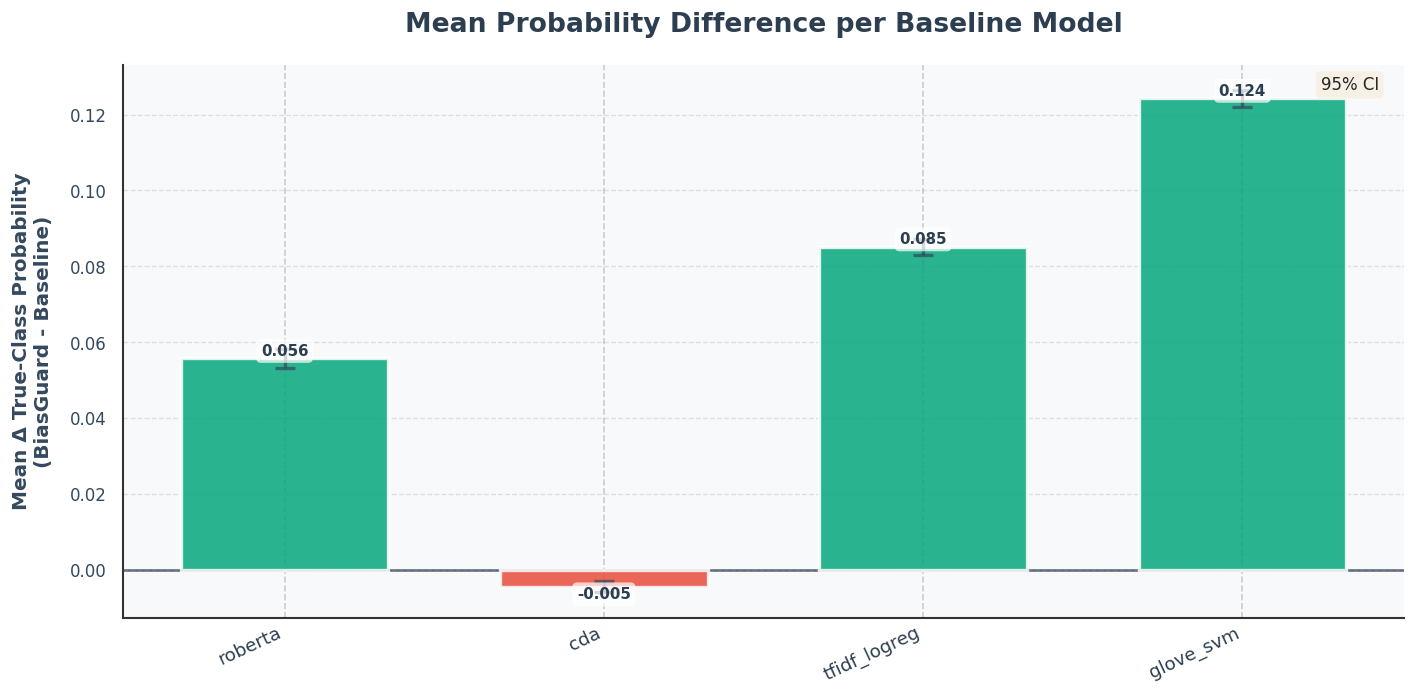

In [26]:
# Bar chart with mean differences and CI - Enhanced styling
fig, ax = plt.subplots(figsize=(12,6), dpi=120)

# Set clean background
ax.set_facecolor('#F8F9FA')
fig.patch.set_facecolor('white')

x = np.arange(len(paired_summary))
means = paired_summary['paired_t_mean_diff_trueclass_proba'].fillna(0)
ci_low = paired_summary['paired_t_ci95_low'].fillna(0)
ci_high = paired_summary['paired_t_ci95_high'].fillna(0)

# Create color mapping - positive values in one color, negative in another
bar_colors = ['#06A77D' if m >= 0 else '#E74C3C' for m in means]

# Plot bars with gradient-like effect
bars = ax.bar(x, means, width=0.65, color=bar_colors, 
              edgecolor='white', linewidth=2, alpha=0.85)

# Add error bars with refined styling
err_lower = means - ci_low
err_upper = ci_high - means
ax.errorbar(x, means, yerr=[err_lower, err_upper], 
            fmt='none', capsize=6, capthick=2, 
            ecolor='#34495E', elinewidth=2, alpha=0.7)

# Enhanced labels and title
ax.set_xticks(x)
ax.set_xticklabels(paired_summary['baseline'], rotation=25, ha='right',
                   fontsize=11, fontweight='500', color='#2C3E50')
ax.set_ylabel('Mean Δ True-Class Probability\n(BiasGuard - Baseline)', 
              fontsize=12, fontweight='600', color='#34495E', labelpad=10)
ax.set_title('Mean Probability Difference per Baseline Model', 
             fontsize=16, fontweight='700', pad=20,
             fontfamily='sans-serif', color='#2C3E50')

# Refined zero reference line
ax.axhline(0, color='#2C3E50', linewidth=1.5, linestyle='-', alpha=0.8, zorder=0)

# Add subtle grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=0.8, color='#95A5A6')
ax.set_axisbelow(True)

# Improve tick styling
ax.tick_params(axis='y', labelsize=10, colors='#34495E')
ax.tick_params(axis='x', length=0)  # Hide x-tick marks for cleaner look

# Add value annotations on bars
for i, (bar, mean_val) in enumerate(zip(bars, means)):
    height = bar.get_height()
    if abs(height) > 0.001:  # Only annotate non-trivial values
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=9, fontweight='600', color='#2C3E50',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='none', alpha=0.7))

# Add confidence interval annotation
ax.text(0.98, 0.98, '95% CI', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Clean up spines
sns.despine(left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

Positive bars mean BiasGuard assigns higher probability to the true class vs the baseline — which is desirable (more confident correct predictions). Error bars are 95% CIs.

#### 8. Discussion & Deployment Guidance
- **BiasGuard Pro**: Highest recall & F1 → stronger safety net for biased content without severe precision sacrifice.
- **CDA**: Slight accuracy / precision edge; recall gap means more misses. Ideal as a shadow model for drift checks.
- **Others (RoBERTa / TF-IDF / GloVe-SVM)**: Performance & confidence gaps confirmed by effect sizes and probability lifts.
- Statistical tests show improvements are **not random variance**; paired probability deltas reflect real confidence gains.

<details style="border:1px solid #ccc;border-radius:8px;padding:8px 12px;">
<summary style="font-weight:600;cursor:pointer;">Operational Recommendations</summary>
<ul style="margin-top:8px;">
<li><strong>Primary Model:</strong> Deploy BiasGuard Pro behind an API with version tagging.</li>
<li><strong>Shadow Validation:</strong> Run CDA asynchronously on 5–10% of traffic; log divergences.</li>
<li><strong>Threshold Audits:</strong> Re-evaluate precision/recall monthly using fresh labeled samples.</li>
<li><strong>Drift Signals:</strong> Monitor distribution shift in input text embeddings; trigger re-training if KL divergence > preset threshold.</li>
<li><strong>Fairness Spot Checks:</strong> Periodically evaluate subgroup recall/precision to avoid hidden performance cliffs.</li>
</ul>
</details>

#### 9. Concise Conclusion
> **BiasGuard Pro** is production‑ready for bias detection use‑cases where missing harmful / biased content is the dominant risk. Its recall advantage is statistically robust and practically meaningful.

**Next Action Checklist:**
1. Integrate BiasGuard Pro inference endpoint → add latency + resource monitoring.
2. Implement CDA shadow pipeline → daily divergence report.
3. Schedule monthly fairness audit notebook → auto-email summary.
4. Archive current metrics & raw predictions for reproducibility (data versioning).

---
<sub>Presentation generated with Plotly + Matplotlib; figures saved to `figures/` for slide decks.</sub>
